In [1607]:
from Photo_asm import molecule_struct as ms
from Photo_asm import correlation_strunct as cs
from Photo_asm import pairwise_cross_corr as pc
from Photo_asm import string_graph as sg
from Photo_asm import consensus as cn
from scipy import ndimage
import numpy as np
import networkx as nx
from numba import jit,njit,prange
from math import sqrt
import pickle


import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [10, 4]
from itertools import combinations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Yeast assembly assessment

I found discontinious assemblies (araund 10 molecules max. instead of 30 to 40 molecules **\* *1***) when I chose the top 20 bidirectional molecules the graph. This was also reflected to the eggplant assembly. All this lead me to assess the set of pairs of molecules which were found to match bidirectionally in the alignment back to the molecules used to assemble the BNG chromosomes. There I found out that a small fraction (around 2000 out of 7077) of molecules were used in the BNG assembly and possibly many of these pairs were not overlapping with onthers (this would explain the discontinuity in the graph). Then I checked if top 10 molecule space (instead of the bi-directional search) contains more of the true pairs (alignments) and unique molecules. Here I found 20938 pairs and 5664 molecules. This count is very few considering the coverage (7077 molecules cover 100x ofc this is lower as for each overlap we need 8 nicks).

When we checked what the top 10 molecule pair space occupies, we found out that around 20% percent of the space was occupied by merely 38 molecules (1% of the molecules). Thus, we went further to try removing these molecules to see what changes. The results were only slightly improved or not improved (by removing different numbers of most frequent molecules).

Next, I normalized the matrix and re-sorted. This gave me better results..


Type | Depth |Unique mols. | True Pairs 
-----|-------|----|-------
Original| 10 | 5664 | 20938   
Original| 20 | 5917 | 39425
Original| 50 | 6187 | 80710
Original| 100 | 6385 | 125941
Original| 150 | 6520 | 156452
Normalized| 10  | 6013 | 19611
Normalized| 20  | 6400 | 37042
Normalized| 50  | 6702 | 78797
Normalized| 100  | 6881 | 128571
Normalized| 150  | 6941 | 163721


Then most frequently top 1% was removed and retested:

Type | Depth |Unique mols. | True Pairs 
-----|-------|----|-------
Original | 20 |  5930  | 41829
Original | 150 | 6521 | 165240
Normalized| 20  | 6283 | 36121
Normalized | 150 |6913 | 162560


### Are these pairs enough?

At this point we need to confirm that it is plausable to create an assembly graph which will hold sufficient information to obtain chromosome wide OM contigs. A good indication on the quality and sufficiency of alignments being made is to try to see if the correct (BNG) alignments are picked up in the second stage (alignment) of our method. I tested this by creating an assembly graph by using the BNG molecules which are fished out from our naive approach. By using top 100 molecules per molecule gave us around 128571 pairs of 6881 BNG molecules (see first table). 31285 out of these 128571 pairs were picked up in the alignment step. These alignments were used to create an assembly graph. (I'm looking into the assemblies right now.)

Next, I went further to find out how many alignments were missed by the initial cross-correlation step. For this, I found all possible pairs from BNG dataset and fed them into the alignment step by skipping the initial cross-correlation step. This resulted in around 70000 pairs being found. Therefore, our initial cross-corr step used for pairing have lost more than half of the pair information leading to a more disconnected graph.

### Are these alignments enough?

I'm currently working on this to obtain longest paths in the graph. The Networkx library is a bit buggy in doing this due to cyclic paths. The strategy here is to iterate over extending high centrality nodes in the graph and storing the paths found. Each found path will be removed from the graph and iterated. Lastly, I'll sort the paths in terms of their lengths and choose the top ones to inspect. This is a greedy approach but the easiest way to assess the quality for now.

The graph assembly from direct BNG alignments will then be compared to our approach to see if we are able to obtain similar paths.

#### BNG directed pairing and assembly

Here, we should be able to assemble of chromosomes. First try didn't work due to cycle paths. Will have to run betweenness.

### Overview of molecule alignment rate and BNG bias

One of the apparent result from pairs obtained by the all vs all cross-corr results is that a large percentage of the molecules do not align to anything else (this may be the reason why BNG method used only around 7070 molecules in total out of the 85500 molecules). Therefore, these molecules can be removed from our matrix to make the computations faster. To filter out the non-aligning molecules, molecule pairs obtained from the top 5 space was sent to the alignment phase. The resulting alignments from here were subtracted to obtained unused molecule set which were removed from the matrix. 

Out of the 85500 molecules, around 20000 were found to be aligning molecules. These molecules include 80% of the BNG molecules. One of the issues with these tests is that the molecules used by BNG can be biased towards their approach and may not be the perfect dataset to be used as the "golden truth".

### BNG independent assembly

A BNG independent naive approach would be to use the top 100 space results from all molecules to create an assembly graph. This is being done right now. This approach will be compared to the BNG directed approach.

### Saturating pairs by a graph directed approach

One of the problems with our current approach is the hard threshold for obtaining the top matches/pairs. In addition, the all vs all cross correlation values is biased towards the large overlap molecule matches and taking the top molecules may remove shorter overlaps even though they are sufficient in the alignment phase. This can be improved by creating a molecule pair graph and creating edges between molecules which have common molecule pairs.

The pairs produced from this way lead to around 200,000 true alignments between the 20,000 molecules which were used. This indicates that adding the neighboring pairs considerably increased the alignment coverage. However, a large proportion of the pairs were containing/contained pairs. This is due to taking top 6 (neighbor addition increases the number of pairs to a great degree and takes time to process). If we take top 50-100 this will be considerably improved, however, it will also scale up the time it would take to align and make it unfeasable to perform quick assessment of graphs.


### Current graph structure and possible improvements

The graph structure being used removes the contained molecules. However, the contained molecules can be linked to molecules to which the containing molecule is not linked because of our hard thresholds. This creates disconnections in the graph. One way may be to include these contained edges in the graph and use them to connect the paths made by the containing molecules.

Update: This can be solved by processing the graph edges where the contained nodes are used to make links with 



In [ ]:
# del normalized_matrix
distance_matrix = np.load("./matrix_yeast.npy")

In [ ]:
sorted_matrix = np.load("./yeast_sorted.npy")

In [6]:
ids = np.load("/mnt/scratch/akdel/pycharm/mols_yeast_bng_ids.npy", encoding="bytes")

In [2]:
mols = np.load("/mnt/scratch/akdel/pycharm/mols_yeast_bng_mols.npy", encoding="bytes")

In [3]:
log_mols = np.load("/mnt/nexenta/akdel001/phd/Code/photomap2/photoasm2/yeast_check.mem_log.npy")

In [4]:
pkl_files = [open("./contained.pkl", "rb"), open("./orig_to_xmap.pkl", "rb"), open("./overlaps.pkl", "rb")]
contained, orig_to_xmap, overlaps = [pickle.load(x,fix_imports=True) for x in pkl_files]
[x.close() for x in pkl_files]
xmap_to_orig = dict()
for m1,m2 in orig_to_xmap.items():
    xmap_to_orig[m2] = m1

In [7]:
orig_to_ids = {}
for i in range(ids.shape[0]):
    orig_to_ids[ids[i]] = i

In [8]:
print(len(overlaps),
      len(orig_to_xmap),
      len(xmap_to_orig))

7300 217889 217889


In [ ]:
chr1_mols_f = open("./chr1_mols.pkl", "rb")
chr1_mols_idx = pickle.load(chr1_mols_f)
chr1_ids = []
for _id in chr1_mols_idx:
    try:
        chr1_ids.append(orig_to_ids[xmap_to_orig[_id]])
    except:
        pass
chr1_mols_f.close()

chr14_ids = []
for _id in chr14_overlaps.keys():
    try:
        chr14_ids.append(orig_to_ids[xmap_to_orig[_id]])
    except:
        pass
chr1_mols_f.close()


In [ ]:
not_chr14_mols = np.sort(list(set(range(len(mols))) -  set(chr14_ids)))
print(not_chr14_mols.shape)

In [ ]:
xmap_to_orig[18987017]

In [ ]:
chr1o_f = open("./chr1_overlaps.pkl","rb")
chr14o_f = open("./chr14_overlaps.pkl","rb")
chr14o_ff = open("./chr14_overlaps_forw.pkl","rb")
chr1_overlaps = pickle.load(chr1o_f)
chr14_overlaps = pickle.load(chr14o_f)
chr14_overlaps_forward = pickle.load(chr14o_ff)
chr1o_f.close()
chr14o_f.close()
chr14o_ff.close()


# Functions:

In [9]:
def assemble_from_path(mollist, logmollist):
    print(mollist[0].shape)
    if len(mollist) == 1:
        return mollist[0]
    mol1 = ms.MoleculeNoBack(mollist[0],5)
    mol2 = ms.MoleculeNoBack(mollist[1],5)
    lmol1 = ms.MoleculeNoBack(logmollist[0],1)
    lmol2 = ms.MoleculeNoBack(logmollist[1],1)
    lcorr = cs.CorrelationStruct(lmol1, lmol2, bylength=250)
    lcorr.correlate_with_zoom((1,1))
    corr = cs.CorrelationStruct(mol1,mol2)
    corr.correlate_with_zoom((1,1))
    lz = sg.assemble_pair(lcorr)
    lcorr.new_long = corr.new_long
    lcorr.new_short = corr.new_short
    z = sg.assemble_pair(lcorr)
    mollist = mollist[2:]
    logmollist = logmollist[2:]
    mollist.insert(0, z)
    logmollist.insert(0,lz)
    return assemble_from_path(mollist, logmollist)

def corrs_from_graph(graph):
    pairs = []
    for edge in graph.edges():
        p1,p2 = (int(edge[0][:-2]), int(edge[1][:-2]))
        pairs.append((p1,p2))
    return pairs

def obtain_perfect_BNG_graph(BNG_overlaps):
    graph = nx.DiGraph()
    for k in BNG_overlaps:
        try:
            current_id = orig_to_ids[xmap_to_orig[k]]
        except KeyError:
            continue
        for k2 in BNG_overlaps[k]:
            try:
                to_id = orig_to_ids[xmap_to_orig[k2]]
            except KeyError:
                continue
            graph.add_edge(current_id, to_id)
    return graph

def get_pairs_from_BNG_overlaps(BNG_overlaps):
    pairs = []
    for k in BNG_overlaps:
        try:
            current_id = orig_to_ids[xmap_to_orig[k]]
        except KeyError:
            continue
        for k2 in BNG_overlaps[k]:
            try:
                to_id = orig_to_ids[xmap_to_orig[k2]]
            except KeyError:
                continue
            yield (current_id, to_id)

def BNG_graph_pair_filter(pairs, BNG_graph):
    second_graph = nx.DiGraph()
    for p1,p2 in pairs:
        if BNG_graph.has_edge(p1,p2):
            second_graph.add_edge(p1,p2, TP=True)
        elif BNG_graph.has_edge(p2,p1):
            second_graph.add_edge(p2,p1, TP=True)
        else:
            second_graph.add_edge(p1,p2, TP=False)
    return second_graph
        
    
    
def get_pairs_in_range(argsorted_array, r):
    pairs = []
    for mol_id1 in range(argsorted_array.shape[0]):
        for mol_id2 in argsorted_array[mol_id1][::-1][r[0]:r[1]]:
            if (mol_id1 == mol_id2):
                continue
            pairs.append((int(mol_id1), int(mol_id2)))
    return pairs

def set_graph_from_edges(pairs):
    nodes = set()
    for p1,p2 in pairs:
        nodes.add(p1)
        nodes.add(p2)
    set_graph = dict.fromkeys(nodes)
    [set_graph.update({x:set()}) for x in set_graph]
    
    for p1,p2 in pairs:
        set_graph[p1].add(p2)
        set_graph[p2].add(p1)
    return set_graph

def increase_graph_density(set_graph, depth=1):
    if depth == 0:
        print("done")
        return set_graph
    else:
        depth -= 1
        extension = dict.fromkeys(set_graph.keys())
        [extension.update({x:set()}) for x in extension]
        for pnode in set_graph:
            for p1,p2 in combinations(set_graph[pnode], 2):
                try:
                    extension[p1].add(p2)
                except KeyError:
                    pass
                try:
                    extension[p2].add(p1)
                except KeyError:
                    pass
        for pnode in extension:
            set_graph[pnode] = extension[pnode] | set_graph[pnode]
        return increase_graph_density(set_graph, depth)

def increase_graph_density_extender(set_graph, depth=1):
    if depth == 0:
        return None
    else:
        depth -= 1
        extension = dict.fromkeys(set_graph.keys())
        [extension.update({x:set()}) for x in extension]
        for pnode in set_graph:
            for p1,p2 in combinations(set_graph[pnode], 2):
                try:
                    extension[p1].add(p2)
                except KeyError:
                    extension[p1] = set([p2])
                try:
                    extension[p2].add(p1)
                except KeyError:
                    extension[p2] = set([p1])
        for pnode in extension:
            try:
                set_graph[pnode] = extension[pnode] | set_graph[pnode]
            except KeyError:
                set_graph[pnode] = set(list(extension[pnode]))
        return increase_graph_density_extender(set_graph, depth)


    
def get_pairs_from_graph(set_graph):
    pairs = list()
    for node in set_graph:
        for cnode in set_graph[node]:
            pairs.append((node, cnode))
    return pairs
    
def check_pair_in_BNG(pair, mode="overlap"):
    if mode == "overlap":
        method = overlaps
    elif mode == "contain":
        method = contained
    else:
        return False
    try:
        m1, m2 = [orig_to_xmap[ids[x]] for x in pair]
    except KeyError:
        return False
    try:
        if m2 in method[m1]:
            return True
        else:
            return False
    except KeyError:
        return False

def check_molecule_in_BNG(molid):
    bnx_id = ids[molid]
    try:
        xmap_id = orig_to_xmap[bnx_id]
    except KeyError:
        return False
    if xmap_id in list(overlaps.keys()):
        return True
    else:
        return False

def count_true_pairs(_pairs, mode="overlap"):
    res = 0
    true_mols = set()
    matching_pairs = list()
    for p in _pairs:
        if check_pair_in_BNG(p, mode=mode):
            true_mols.add(p[0])
            true_mols.add(p[1])
            res += 1
            matching_pairs.append(p)
        elif check_pair_in_BNG(list(p)[::-1], mode=mode):
            true_mols.add(p[0])
            true_mols.add(p[1])
            res += 1
            matching_pairs.append(p)
    return res, len(true_mols), matching_pairs


def get_pairs(matrix, argsorted_array, depth):
    pairs = []
    for mol_id1 in range(argsorted_array.shape[0]):
        for mol_id2 in argsorted_array[mol_id1][-depth:]:
            if (mol_id1 == mol_id2):
                continue
            pairs.append((int(mol_id1), int(mol_id2)))
    return pairs


def normalized_cross_corr(pairs, limit, lp=0.7, cp=0.65):
    from time import time
    corrs = []
    n = 0
    t = time()
    for molid_1,molid_2 in pairs[:limit]:
        n += 1
        molid_1 = int(molid_1)
        molid_2 = int(molid_2)
        mol1 = ms.MoleculeNoBack(mols[molid_1],4)
        mol2 = ms.MoleculeNoBack(mols[molid_2],4)
        lmol1 = ms.MoleculeNoBack(log_mols[molid_1],5)
        lmol2 = ms.MoleculeNoBack(log_mols[molid_2],5)
        lcorr = cs.CorrelationStruct(lmol1, lmol2, bylength=250)
        lcorr.correlate_with_zoom((1,1))
        corr = cs.CorrelationStruct(mol1,mol2)
        corr.correlate_with_zoom((1,1))
        if n % 1000 == 0:
            print("%s percent is done" % (n/len(pairs)*100))
            print("number of corrs: %s" % len(corrs))
        if lcorr.max_score >= lp and corr.max_score >= cp:
            corrs.append((corr, (molid_1, molid_2)))
    return corrs

def pairs_from_corrs(_corrs):
    return [x for y,x in _corrs]

def plot_corrs(corrs):
    for corr,pair_id in corrs:
        try:
            print(pair_id)
            z = sg.assemble_pair(corr, plot=True)
            plt.plot(z[1])
            plt.plot(z[2])
            plt.show()
            print(corr.max_score)
            
        except:
            continue

def remove_nodes(graph, node_ids):
    for node in node_ids:
        del graph[node]
    return graph

def get_random_path(graph, start_node, centrality, res=[]):
    next_nodes = [x for x in graph[start_node].keys()]
    if not next_nodes:
        return res
    sorted_next_nodes = sorted([(centrality[x],x) for x in next_nodes])[::-1]
    current_res = None
    for i in range(len(sorted_next_nodes)):
        if int(sorted_next_nodes[i][1][:-2]) in res:
            to_del = sorted_next_nodes[i][1]
            pass
        else:
            current_res = sorted_next_nodes[i][1]
            break
    if current_res != None:
        res.append(int(current_res[:-2]))
    else:
        pass
    return get_random_path(graph, current_res, centrality, res)

def plot_pairs(pair):
    p1 = pair[0]
    p2 = pair[1]
    mol1 = ms.MoleculeNoBack(mols[p1],4)
    mol2 = ms.MoleculeNoBack(mols[p2],4)
    corr = cs.CorrelationStruct(mol1,mol2)
    corr.correlate_with_zoom((1,1))
    try:
        z = sg.assemble_pair(corr, plot=True)
        plt.plot(z[1])
        plt.plot(z[2])
        plt.show()
        print(corr.max_score)
        print(p1,p2)
    except:
        plt.plot(corr.new_short)
        long_overlap = sorted(corr.long_overlap)
        plt.plot(corr.new_long[long_overlap[0]: long_overlap[1]])
        print(corr.max_score)
        print("contained")
    print(sg.correlation_to_edge(corr, (p1,p2)))
#  61835, 56603, 73002
#  15585, 26287, 24923
# plot_pairs((35156, 70902))
# plot_pairs((73002, 35156))
# plot_pairs((73002, 70902))
# plot_pairs((35156, 56603))
# plot_pairs((26287,24923))

def normalized_cross_corr_logs(pairs, limit, lp=0.7):
    from time import time
    corrs = []
    n = 0
    t = time()
    for molid_1,molid_2 in pairs[:limit]:
        n += 1
        molid_1 = int(molid_1)
        molid_2 = int(molid_2)
        lmol1 = ms.MoleculeNoBack(log_mols[molid_1],4)
        lmol2 = ms.MoleculeNoBack(log_mols[molid_2],4)
        lcorr = cs.CorrelationStruct(lmol1, lmol2, bylength=250)
        lcorr.correlate_with_zoom((1,1))
        if n % 1000 == 0:
            print("%s percent is done" % (n/len(pairs)*100))
            print("number of corrs: %s" % len(corrs))
        if lcorr.max_score >= lp:
            corrs.append((lcorr, (molid_1, molid_2)))
    return corrs

def is_repeat(_mol):
    result = ndimage.gaussian_filter1d(np.correlate(_mol, _mol[::-1], mode='same'),sigma=1.5)
    mol_ = ms.MoleculeNoBack(result, snr=1.5)
    if len(mol_.nick_coordinates) < 6:
        return False
    nicks = np.array(mol_.nick_coordinates[0:6])
    diffs = np.abs(nicks[:5]-nicks[1:6])
    if (np.max(diffs) - np.min(diffs)) <= 2 and np.mean(diffs) >= 10:
        return True
    else:
        return False

In [10]:
@njit(parallel=True)
def normalize_matrix(matrix, max_values, normalized_matrix):
    for i in prange(matrix.shape[0]):
        for j in prange(matrix.shape[0]):
            normalized_matrix[i,j] = matrix[i,j]/(sqrt(max_values[i]*max_values[j]))

In [11]:
@njit(parallel=True)
def argsort_numba(matrix, argsorted):
    for i in prange(matrix.shape[0]):
        argsorted[i] = np.argsort(matrix[i])

In [12]:
@njit(parallel=True)
def argsort_into_partial_array(matrix, res):
    topnum = res.shape[1]
    for i in prange(matrix.shape[0]):
        res[i,:] = np.argsort(matrix[i])[-topnum:]

In [1610]:
np.vstack([[1,1],[1,1]])

array([[1, 1],
       [1, 1]])

In [1605]:

@numba.njit(parallel=True)
def clear_molecules(new_matrix, mol_indices):
    for i in prange(mol_indices.shape[0]):
        molid = mol_indices[i]
        new_matrix[molid,:] = 0.0000001
        new_matrix[:,molid] = 0.0000001

@numba.njit(parallel=True)
def make_new_array(old, zeros):
    for i in prange(old.shape[0]):
        zeros[i,:] = old[i]

# @numba.jit
# def prange_test(A,s):
#     for i in range(A.shape[0]):
#         s += A[i]
#     return s

TypeError: super(type, obj): obj must be an instance or subtype of type

In [1606]:
z = np.arange(100000000)
prange_test(z,0)


TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
normalized_matrix = np.zeros(distance_matrix.shape)
maximum_for_all = np.max(distance_matrix, axis=1)
normalize_matrix(distance_matrix, maximum_for_all, normalized_matrix)

In [ ]:
# del orig_argsorted
del distance_matrix
orig_argsorted = np.zeros((normalized_matrix.shape[0], 10))
argsort_into_partial_array(normalized_matrix, orig_argsorted)

In [ ]:
pairs = get_pairs(normalized_matrix, orig_argsorted, 10)
print(len(pairs))

In [ ]:
gr = set_graph_from_edges(pairs)

In [ ]:
pairs2 = get_pairs_from_graph(gr)

In [ ]:
len(pairs2),len(pairs)

In [ ]:
corrs = normalized_cross_corr(pairs,len(pairs),lp=0.7,cp=0.68)

In [ ]:
381/2

In [ ]:
corr_pairs = pairs_from_corrs(corrs)
corr_graph = set_graph_from_edges(corr_pairs)
nodes_used = set(list(corr_graph.keys()))
nodes_not_used = set(list(range(len(mols)))) - nodes_used
print(len(nodes_not_used), len(nodes_used))

In [ ]:
# new_matrix = np.zeros(normalized_matrix.shape)
# make_new_array(normalized_matrix, new_matrix)
clear_molecules(normalized_matrix, np.sort(list(nodes_not_used)))
del orig_argsorted
orig_argsorted = np.zeros((normalized_matrix.shape[0], 10))
argsort_into_partial_array(normalized_matrix, orig_argsorted)

In [ ]:
to_filter = []
pairs_ = get_pairs(normalized_matrix, orig_argsorted, 10)
len(pairs_)
pairs_ = [(p1,p2) for p1,p2 in pairs_ if p1 in nodes_used and p2 in nodes_used and p1 not in to_filter and p2 not in to_filter]
print(len(pairs_))

In [ ]:
gr = set_graph_from_edges(pairs_)
# print(len(gr))
# remove_nodes(gr, nodes_not_used)
print(len(gr))
increase_graph_density(gr, 1)
print(len(gr))
graph_pairs = get_pairs_from_graph(gr)
print(len(graph_pairs))


In [ ]:
corr_files = ["/tmp/corrs/" + x for x in listdir("/tmp/corrs/")]
alignment_corrs = []
# for x in corr_files:
#     try:
#         for y in np.load(x):
#     for r in y
_ = [[alignment_corrs.append(y) for y in np.load(x)] for x in corr_files]

In [ ]:
np.save("graph_pairs.npy",graph_pairs)

In [ ]:
g = nx.Graph(gr)
cent = nx.centrality.degree_centrality(g)
_ = plt.hist(cent.values(), bins=30)
sorted_cent = sorted([(x,y) for y,x in cent.items()])[::-1]
sorted_cent[50:60]
to_filter = [x for x,y in cent.items() if y >= 0.05]
print(to_filter)

In [ ]:
plt.plot(mols[1913])

In [ ]:
corrs_strict4 = normalized_cross_corr(graph_pairs, len(graph_pairs), lp=0.6, cp=0.6)

In [ ]:
ps = pairs_from_corrs(corrs_strict4)
len(ps)

In [ ]:
log_corrs4 = normalized_cross_corr_logs(ps, len(ps), lp=0.6)

In [ ]:
len(nodes_used)


In [51]:
corr_files = ["./bng_corrs/" + x for x in listdir("./bng_corrs/")]
bng_stretch_corrs = []
_ = [[bng_stretch_corrs.append((y[0],(y[1],y[2]))) for y in np.load(x)] for x in corr_files]

In [52]:
bng_filt = [x for x in bng_stretch_corrs if x[0].max_score > 0.8]
len(bng_filt)

15211

In [1053]:
len(graph_pairs)

3506296

In [14]:
from os import listdir
new_corrsf = ["/mnt/scratch/akdel/ass_corrs2/" + x for x in listdir("/mnt/scratch/akdel/ass_corrs2/")]
new_corrs = []
# for x in corr_files:
#     try:
#         for y in np.load(x):
#     for r in y
_ = [[new_corrs.append(y) for y in np.load(x)] for x in new_corrsf]

In [1083]:
filtered_lcorrs = [x for x in log_corrs4 if x[0].max_score > 0.65]
len(filtered_lcorrs)

1011345

In [1278]:
filt_new_corrs = [(x[0], x[-1]) for x in new_corrs if x[0].max_score > 0.75]

In [908]:
len(filt_new_corrs)

880359

In [ ]:
61735
47426
55720
33370
72705
46235
3321
72980
83236
77342
46963
34732
65457
plt.plot(mols[65457])

In [1282]:
rm ./newbnx/*

rm: cannot remove './newbnx/*': No such file or directory


In [ ]:
# np.save('corrs_strict.npy', corrs_strict)
# print(1)
# np.save('corrs_.npy', np.array(corrs_, dtype='O'))
# filt_new_corrs
from Photo_asm import bnx_utils as bnx
from Photo_asm import mqr
qual = mqr.MQR("./mqr_res/", "/mnt/scratch/akdel/tools/RefAligner")
paths = [x for x in qual.corrs_to_paths2(filt_new_corrs, bet_thr=0.018, edge_bet=0.015) if len(x)>3]
# print(len(paths))
# qual.paths_to_bnx(paths, mols, "./newbnx/")
# xmaps = qual.bnx_folder_to_xmaps("/mnt/scratch/akdel/tools/S288C_reference_sequence_R64-2-1_20150113.fasta_Nt.BspQI.cmap", "./newbnx/")


In [1542]:
num = 5
from Photo_asm.consensus import Consensus,nanmed
c = Consensus(filt_new_corrs)
c.from_path_to_space2(paths[num][0],paths[num][1]),paths[num]
path_mols = paths[num][0]
c.fill_contained_space(path_mols,mols, containing=True)
c.fill_contained_space([x for x in list(c.index.keys()) if x not in path_mols],mols,containing=True)
c.fill_contained_space([x for x in list(c.index.keys()) if x not in path_mols],mols,containing=True)
c.fill_contained_space([x for x in list(c.index.keys()) if x not in path_mols],mols,containing=False)
# c.fill_contained_space([x for x in list(c.index.keys()) if x not in path_mols],mols)

(67200, 39462)
{'type': (True, True), 'overlap': ((71, 534), (0, 463)), 'short': 39462, 'short_ori': False, 'short_len': 506, 'long_len': 534}


In [1543]:
print(len(c.index))

421


In [1407]:
len(c.index)

1573

In [402]:
def find_contained_mols(mol_id, corr_stream):
    for corr, pair in corr_stream:
        if mol_id in pair:
            edge = sg.correlation_to_edge(corr, pair)
            if edge["contained"] == True and edge["long_id"] == mol_id:
                yield edge["short_id"],corr.reversed, corr.zoom


In [637]:
to_arrs = [find_contained_mols(x, filt_new_corrs) for x in path_mols]

/mnt/nexenta/akdel001/phd/Tools/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


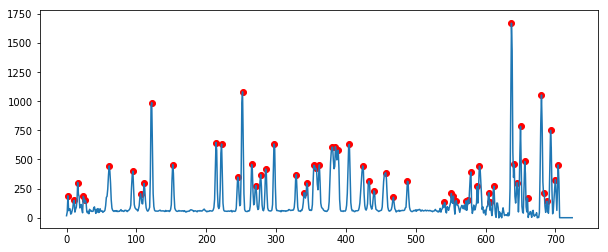

In [1552]:

# median2 = np.nan_to_num(np.nanmedian(arr,axis=0))
# mean = np.nan_to_num(np.nanmean(arr,axis=0))
# quart2 = ndimage.white_tophat(np.nan_to_num(np.nanpercentile(arr, 75,axis=0)), structure=np.ones(10))+20
quart = np.nan_to_num(np.nanpercentile(arr, 55,axis=0))
# plt.plot(quart[500:1500])
# plt.plot(quart2[500:1500])
db.molecules_to_bnx([(x,x) for x in [quart[50:500]]], zoom_ratio=1, final_ratio=510, bnx_filename="contigx_final.bnx", signal_to_noise_ratio=1.5, bnx_template_path="../photomap/bnx_head.txt")
# db.molecules_to_bnx([(x,x) for x in [quart2[:2750]]],zoom_ratio=20, final_ratio=510, bnx_filename="contig4_tophat.bnx", signal_to_noise_ratio=2, bnx_template_path="../photomap/bnx_head.txt")
# db.get_bnx_info?
plt.plot(quart)
plt.scatter(bnx.get_peaks(quart, median=65, snr=2), [quart[x] for x in bnx.get_peaks(quart, median=65, snr=2)], c="r")

In [1554]:
quart = np.nan_to_num(np.nanpercentile(arr, 55,axis=0))
quart_unopt = np.nan_to_num(np.nanpercentile(arr, 55,axis=0))
# plt.rcParams['figure.figsize'] = [40, 4]
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(quart[:500][::-1], lw=2, c='black')
plt.scatter(bnx.get_peaks(quart[:500][::-1], median=60, snr=2), [quart[:500][::-1][x] for x in bnx.get_peaks(quart[:500][::-1], median=60, snr=2)], c="r")
# plt.savefig("longplot.png", dpi=300)
plt.show()
# plt.plot(quart[:600], lw=2, c="black")
# plt.savefig("shortplot.png", dpi=300)
# plt.show()
# plt.plot(quart_unopt[:600], lw=2, c="black")
# plt.savefig("shortplot_unopt.png", dpi=300)
# plt.show()

/mnt/nexenta/akdel001/phd/Tools/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [1190]:
np.median(quart)

75.034999999999997

In [1544]:
min([x.begin for x in c.space.all_intervals]), max([x.end for x in c.space.all_intervals])
arr = np.zeros((len(c.space.all_intervals),max([x.end for x in c.space.all_intervals])+100), dtype=float)
# arr = np.zeros((len(c.space.all_intervals),1000), dtype=float)
arr[:] = np.NaN
i = 0
c.space.all_intervals

for start,stop,mol_id,flip in sorted([(x.begin,x.end,x.data[0],x.data[1]) for x in c.space.all_intervals if x.data != "consensus"]):
    if flip == False:
        m = mols[mol_id][::-1]
    else:
        m = mols[mol_id]
    try:
        arr[i,start:start+m.shape[0]] = m
        i += 1
    except:
        continue
# for j in range(len(arr)):
#     plt.plot(arr[j]+j*2000)
# plt.imshow(arr)
# plt.show()

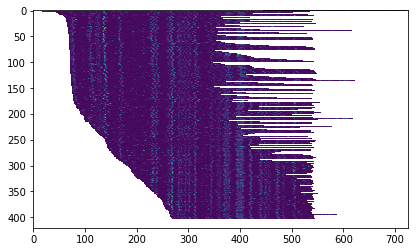

In [1545]:
plt.rcParams['axes.facecolor'] = 'white'
plt.imshow(arr)
plt.show()

In [1572]:

jit(parallel=True)
def corr_parr(mols):
    res = np.zeros((mols.shape[0],mols.shape[0]))
    for i in prange(res.shape[0]):
        for j in prange(res.shape[0]):
            res[i,j] = np.max(mols[i]*mols[j])
    return res

In [1573]:
asd = np.zeros((5000,370))
asd[:] = mols[0]
corr_parr(asd)

array([[ 14825657.1681,  14825657.1681,  14825657.1681, ...,
         14825657.1681,  14825657.1681,  14825657.1681],
       [ 14825657.1681,  14825657.1681,  14825657.1681, ...,
         14825657.1681,  14825657.1681,  14825657.1681],
       [ 14825657.1681,  14825657.1681,  14825657.1681, ...,
         14825657.1681,  14825657.1681,  14825657.1681],
       ..., 
       [ 14825657.1681,  14825657.1681,  14825657.1681, ...,
         14825657.1681,  14825657.1681,  14825657.1681],
       [ 14825657.1681,  14825657.1681,  14825657.1681, ...,
         14825657.1681,  14825657.1681,  14825657.1681],
       [ 14825657.1681,  14825657.1681,  14825657.1681, ...,
         14825657.1681,  14825657.1681,  14825657.1681]])

In [1566]:
from Photo_asm.consensus import nanmed,optimize_consensus, nan_to_1

optimize_consensus(arr,10)
# for i in range(len(arr)):
#     plt.plot(arr[i]+2000*i)
plt.plot(np.nanpercentile(arr,50, axis=0)[:500],c="r")
plt.show()
plt.imshow(arr[:,:500])
plt.show()

/mnt/nexenta/akdel001/phd/Tools/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


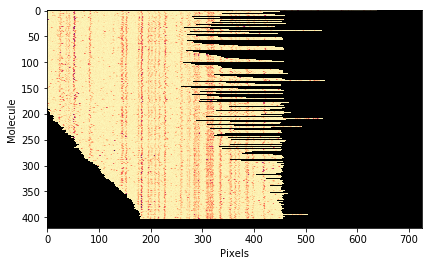

In [1563]:
plt.rcParams['axes.facecolor'] = 'black'
plt.imshow(arr, cmap="magma_r")
plt.xlabel("Pixels")
plt.ylabel("Molecule")
# plt.savefig("unopt_chr4_consensus.png", dpi=300)
plt.show()
# plt.plot((np.max(quart) - quart)/3, lw=3, c="orange")

In [1446]:
plt.imshow(arr[:400,:600], cmap="magma_r")
plt.savefig("unopt_chr4_consensus_end.png", dpi=300)
plt.show()

In [1447]:
# optimize_consensus(arr,7)
plt.imshow(opt_arr, cmap="magma_r")
plt.xlabel("Pixels")
plt.ylabel("Molecule")
plt.savefig("opt_chr4_consensus.png", dpi=300)
plt.show()

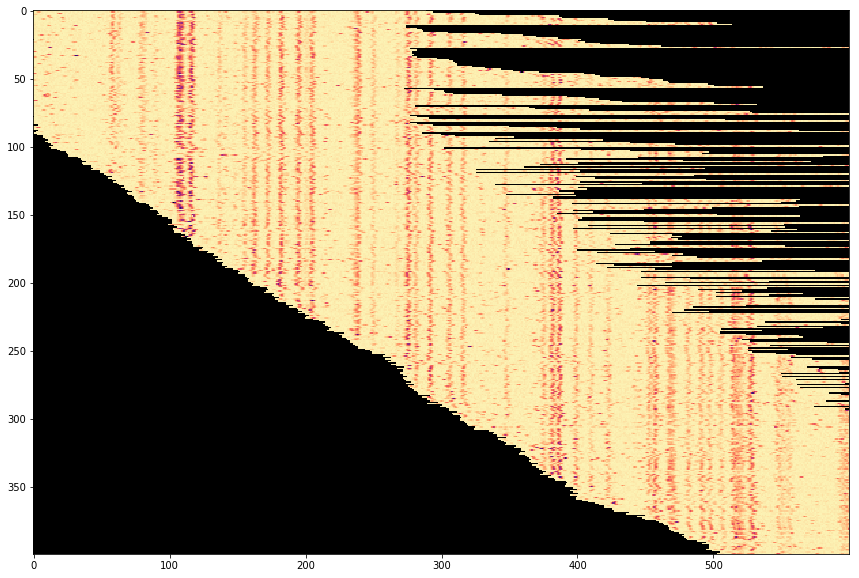

In [1448]:
plt.imshow(opt_arr[:400,:600], cmap="magma_r")
plt.savefig("opt_chr4_consensus_end.png", dpi=300)
plt.show()

In [1431]:
opt_arr = np.array(arr)

/mnt/nexenta/akdel001/phd/Tools/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/mnt/nexenta/akdel001/phd/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


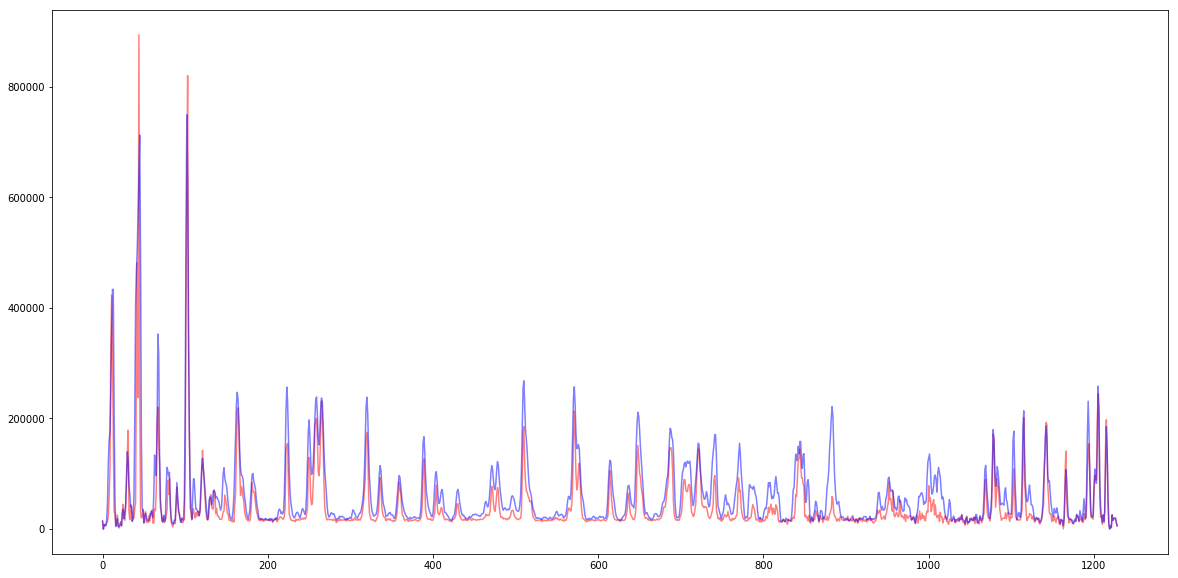

In [934]:
plt.plot(np.nanmedian(arr, axis=0)*j,c="r",alpha=0.5)
plt.plot(np.nanmean(arr, axis=0)*j,c="b",alpha=0.5)
plt.show()

In [568]:
cons = np.nanmedian(arr, axis=0)
new_cons = np.zeros((cons.shape[0], 50))
logcons = np.log1p(cons)
med = np.nanmedian(logcons)
log_cons = np.array([x if x > med * 1.2 else 0 for x in logcons])
cons_mol = ms.MoleculeNoBack(log_cons, 3.5)
matching = []
j = 0
for i in range(len(log_mols))[:100]:
    real_mol = mols[i]
    mol1 = ms.MoleculeNoBack(log_mols[i], 3.5)
    corr = cs.CorrelationStruct(mol1, cons_mol)
    corr.correlate_with_zoom((0.98,1.02))
    if corr.max_score >= 0.9:
        if corr.reversed:
            to_insert = ndimage.zoom(real_mol[::-1], corr.zoom)
        else:
            to_insert = ndimage.zoom(real_mol, corr.zoom)
        try:
            new_cons[min(corr.long_overlap):min(corr.long_overlap)+to_insert.shape[0],j] = to_insert
            j += 1
        except:
            continue
        matching.append((corr, i))
        print(corr.max_score)

/mnt/nexenta/akdel001/phd/Tools/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/mnt/nexenta/akdel001/phd/Tools/anaconda3/lib/python3.6/site-packages/Photo_map/utils.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  bnx_dict["nick_snrs"] = [nick_signal[x] / median for x in bnx_dict["nick_distances"]]
/mnt/nexenta/akdel001/phd/Tools/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ZeroDivisionError: float division

In [ ]:
for i in range(new_cons.shape[1]):
    plt.plot(new_cons[:,i][:500])
    plt.plot(cons[:500],c="r")
plt.show()

In [91]:
sg.fish_out_corr?

Signature: sg.fish_out_corr(id_pair:(<class 'int'>, <class 'int'>), correlation_stream)
Docstring: <no docstring>
File:      /mnt/nexenta/akdel001/phd/Code/photomap2/photoasm2/Photo_asm/string_graph.py
Type:      function


In [1186]:
pwd

'/mnt/nexenta/akdel001/phd/Code/photomap2/photoasm2'

In [ ]:
len(graph_pairs)

In [ ]:
xmaps2 = qual.bnx_folder_to_xmaps("/mnt/scratch/akdel/tools/S288C_reference_sequence_R64-2-1_20150113.fasta_Nt.BspQI.cmap", "./paths/")

### Here we'll be able to see what happens if the BNG molecules are used instead.
#### Do we perform better or worse?
1. 72.16416693478365 %
2. 50.27557445620473 %
3. 86.76216781460869 %
4. 97.5439989309773 %
5. 94.51075289663754 %
6. 94.86442579197772 %
7. 0.0 %
8. 65.45349036044198 %
9. 97.26588226501815 %
10. 97.98981557416131 %
11. 99.18172714988901 %
12. 96.82089166356164 %
13. 97.89733162681988 %
14. 41.60947485592853 %
15. 98.31523984477595 %
16. 91.37977934970417 %

Seems to be similar except some missing chromosomes

corr non strict

1 72.16416693478365 %
2 96.60000199420683 %
3 36.21214095689735 %
4 0.0 %
5 27.021653841679854 %
6 0.0 %
7 47.99424882162754 %
8 35.0853352834383 %
9 97.26588226501815 %
10 0.0 %
11 99.18172714988901 %
12 60.51455435832314 %
13 98.17842171002341 %
14 41.60947485592853 %
15 98.41096380564531 %
16 0.0 %

stricter

1 72.16416693478365 %
2 0.0 %
3 78.98964150517607 %
4 64.42119494729562 %
5 0.0 %
6 95.50071558426488 %
7 78.13554263347419 %
8 97.64786780034709 %
9 97.26588226501815 %
10 97.98981557416131 %
11 99.18172714988901 %
12 92.87119697050346 %
13 14.437368239023499 %
14 0.0 %
15 29.359958980715035 %
16 86.55949182264972 %

using more molecules (thr 0.71, load 0.05):

1 70.98166079747544 %
2 65.79436736281103 %
3 98.1043859119385 %
4 96.76417568654577 %
5 52.92078352855748 %
6 95.50071558426488 %
7 97.74739353528372 %
8 35.0853352834383 %
9 97.26588226501815 %
10 97.98981557416131 %
11 91.67264863430171 %
12 83.88726455625937 %
13 14.06210416634541 %
14 87.18354225101777 %
15 98.41096380564531 %
16 32.25427360765707 %



1 81.54311982405649 %
2 59.627781295337044 %
3 53.683638409387804 %
4 63.61654574657349 %
5 55.23915104814746 %
6 73.25300738792403 %
7 36.43515648028623 %
8 92.93141524501833 %
9 97.26588226501815 %
10 97.22979802795949 %
11 99.18172714988901 %
12 54.832917639365206 %
13 97.93213745216953 %
14 81.80003061761965 %
15 98.41096380564531 %
16 82.32561240080038 %

1 72.16416693478365 %
2 65.07283840443512 %
3 36.21214095689735 %
4 97.5439989309773 %
5 88.72734771282839 %
6 73.25300738792403 %
7 39.33763501270083 %
8 76.61529449859381 %
9 82.92922168610544 %
10 95.96341998359811 %
11 93.08328708618859 %
12 56.31211646528321 %
13 90.48369082734328 %
14 82.92795258939437 %
15 98.31523984477595 %
16 91.37977934970417 %


thr = 0.75 load = 0.005 bet = 0.005
1 72.16416693478365 %
2 65.79436736281103 %
3 98.1043859119385 %
4 78.33342503871276 %
5 94.7869336707897 %
6 95.50071558426488 %
7 89.19769028832587 %
8 60.15273396711744 %
9 97.26588226501815 %
10 97.98981557416131 %
11 91.67264863430171 %
12 94.58698016075189 %
13 88.64823426523361 %
14 81.80003061761965 %
15 98.41096380564531 %
16 91.02421433248502 %

thr = 0.75 load = 0.015, bet = 0.018 (stretch)
1 72.16416693478365 %
2 95.52250711682562 %
3 78.98964150517607 %
4 96.78736404677498 %
5 94.7869336707897 %
6 95.50071558426488 %
7 93.75344779632105 %
8 97.64786780034709 %
9 97.26588226501815 %
10 95.475586530838 %
11 92.61096298619825 %
12 94.74638232185359 %
13 91.04752316900431 %
14 76.47814343057455 %
15 93.20627314712348 %
16 82.09218885910616 %


thr = 0.75 load = 0.015, bet = 0.015 (stretch)

1 0.0 %
2 89.35592104935164 %
3 78.98964150517607 %
4 96.78736404677498 %
5 94.7869336707897 %
6 95.50071558426488 %
7 97.74739353528372 %
8 97.64786780034709 %
9 97.26588226501815 %
10 97.98981557416131 %
11 92.61096298619825 %
12 94.74638232185359 %
13 91.04752316900431 %
14 76.47814343057455 %
15 93.20627314712348 %
16 87.04429456309155 %

thr = 0.67 load = 0.03 bet = 0.03

1 70.98166079747544 %
2 80.19802473813571 %
3 74.45720406457293 %
4 95.14020442439154 %
5 94.7869336707897 %
6 95.50071558426488 %
7 97.74739353528372 %
8 92.93141524501833 %
9 82.92922168610544 %
10 93.6490378196937 %
11 99.18172714988901 %
12 96.82089166356164 %
13 92.57259107340725 %
14 77.06091608955913 %
15 95.1809717734201 %
16 87.85649236777057 %

thr = 0.67 load = 0.03 bet = 0.04

1 70.98166079747544 %
2 73.12619340814933 %
3 74.45720406457293 %
4 95.14020442439154 %
5 94.7869336707897 %
6 95.50071558426488 %
7 97.74739353528372 %
8 92.93141524501833 %
9 82.92922168610544 %
10 93.6490378196937 %
11 99.18172714988901 %
12 96.82089166356164 %
13 92.32630681555337 %
14 72.70322445050455 %
15 95.1809717734201 %
16 87.85649236777057 %

thr=0.67 bet_thr=0.02, edge_bet=0.05

1 70.98166079747544 %
2 65.79436736281103 %
3 58.82824096293636 %
4 94.49944583749283 %
5 52.92078352855748 %
6 95.50071558426488 %
7 97.74739353528372 %
8 92.93141524501833 %
9 96.16214600333502 %
10 97.22979802795949 %
11 96.85328394942573 %
12 96.82089166356164 %
13 90.48369082734328 %
14 72.70322445050455 %
15 95.1809717734201 %
16 87.85649236777057 %



thr=0.66 bet_thr=0.03, edge_bet=0.05

1 79.89078456174991 %
2 65.07283840443512 %
3 98.1043859119385 %
4 97.5439989309773 %
5 94.7869336707897 %
6 82.48868603256876 %
7 97.74739353528372 %
8 90.99404417569865 %
9 74.74835467161161 %
10 89.73560816388806 %
11 97.36707967377666 %
12 96.82089166356164 %
13 85.7998841274422 %
14 77.06091608955913 %
15 98.31523984477595 %
16 71.87165683406285 %

1 72.16416693478365 %
2 0.0 %
3 0.0 %
4 0.0 %
5 0.0 %
6 0.0 %
7 0.0 %
8 91.47811407386386 %
9 0.0 %
10 0.0 %
11 92.61096298619825 %
12 0.0 %
13 22.925363533628378 %
14 86.86218698024645 %
15 0.0 %
16 0.0 %
8,14


thr=0.8 photoasm
1 72.16416693478365 %
2 59.627781295337044 %
3 86.76216781460869 %
4 90.16708720133522 %
5 92.06213803046272 %
6 55.80977062623293 %
7 92.43309773584313 %
8 59.01505146312446 %
9 95.91645608643053 %
10 97.98981557416131 %
11 46.0743714409806 %
12 35.40144250876379 %
13 87.22901572209972 %
14 81.80003061761965 %
15 76.02216221799242 %
16 87.72467419083961 %
[4-6,5-3,7-3,8-2,9-2,10-3,12-2,13-4,14-3,15-3,16-3]
76.8

thr=0.8 bng
1 75.7090409051042 %
2 65.07283840443512 %
3 98.1043859119385 %
4 38.27232305447038 %
5 94.51075289663754 %
6 95.50071558426488 %
7 51.7838909715555 %
8 0.0 %
9 79.89943528686399 %
10 84.02532756088723 %
11 61.70857060129331 %
12 68.03592204217266 %
13 24.95753909597376 %
14 93.90774236570411 %
15 15.703432782966667 %
16 71.75166573662814 %
[4-2, 5-2, 10-2, 12-3, 14-3,16-2]


In [ ]:
BNG_corrs = np.load("BNG_log_corrs.npy")

In [63]:
3+3+3+4+2+1+3+2+2+3+1+3+6+3

39

In [55]:
cmap = bnx.CmapParser("/mnt/scratch/akdel/tools/S288C_reference_sequence_R64-2-1_20150113.fasta_Nt.BspQI.cmap")
cmap.read_and_load_cmap_file()
cmap.get_position_indexes()
cmap.positions_to_intervals()
chrs = sorted([(x[0],y,np.zeros(int(y[1]-y[0])+1)) for y,x in cmap.intervals.items()])


In [56]:
ints2 = [(x.intervals,set([int(l[2]) for l in x.xmap_lines]),y) for x,y in zip(xmaps,paths) if x.xmap_lines]

In [57]:
ints2 = [(x.intervals,set([int(l[2]) for l in x.xmap_lines])) for x in xmaps if x.xmap_lines]

In [ ]:
rm ./chr_bnx2/*

In [ ]:
plt.plot(mols[2119])
# 53252
# 34935
# 33090
# 27653
# 22321

db.molecules_to_bnx([(mols[x],np.zeros(mols[x].shape)) for x in [2119]], 10, 500, "./chr_bnx2/s.bnx","../photomap/bnx_head.txt")
xmaps3 = qual.bnx_folder_to_xmaps("/mnt/scratch/akdel/yeast_workspace_data/Merged_molecules_10/output/contigs/exp_refineFinal1/EXP_REFINEFINAL1.cmap", "./chr_bnx2/")

In [ ]:
[(x.intervals,set([int(l[2]) for l in x.xmap_lines])) for x in xmaps3 if x.xmap_lines]

In [58]:
ints2

[({(296522.0, 432859.0): 1,
   (314589.0, 483437.0): 2,
   (352478.0, 484439.5): 3,
   (352478.0, 545730.0): 5,
   (367524.0, 545730.0): 6,
   (373112.0, 539179.0): 4},
  {5}),
 ({(2000.0, 141757.0): 1,
   (2000.0, 274972.0): 2,
   (125571.0, 273996.0): 3,
   (140406.0, 310657.0): 4,
   (141757.0, 310657.0): 5},
  {3}),
 ({(9493.0, 124393.0): 6,
   (9493.0, 139549.0): 5,
   (9493.0, 251633.0): 4,
   (136604.0, 313554.0): 3,
   (149365.0, 352478.0): 2,
   (207664.0, 373112.0): 1},
  {5}),
 ({(624296.0, 796504.0): 4,
   (641354.0, 796504.0): 3,
   (659683.0, 857813.0): 2,
   (724461.0, 983155.0): 1},
  {12}),
 ({(327526.0, 488279.0): 5,
   (341932.0, 507877.0): 4,
   (375154.0, 556808.0): 3,
   (413115.0, 610340.0): 2,
   (468447.0, 737375.0): 1},
  {14}),
 ({(831596.0, 1062735.0): 1,
   (919325.0, 1085467.0): 2,
   (975099.0, 1230898.0): 3,
   (1105534.0, 1266460.0): 4,
   (1128951.0, 1281811.0): 5},
  {4}),
 ({(496440.0, 673361.0): 3, (552974.0, 724461.0): 2}, {12}),
 ({(903856.0, 1074

In [65]:
3+4+2+1+2+1+3+1+3+1+2

23

In [64]:
# []
chr_lengths = np.array([230218,813184,
                       316620, 1531933,
                        576874, 270161,
                        1090940, 562643,
                        439888, 745751,
                        666816, 1078177,
                        924431, 784333,
                        1091291, 948066])
current = [float(x.split()[1]) for x in 
"""1 75.7090409051042 %
2 65.07283840443512 %
3 98.1043859119385 %
4 38.27232305447038 %
5 94.51075289663754 %
6 95.50071558426488 %
7 51.7838909715555 %
8 0.0 %
9 79.89943528686399 %
10 84.02532756088723 %
11 61.70857060129331 %
12 68.03592204217266 %
13 24.95753909597376 %
14 93.90774236570411 %
15 15.703432782966667 %
16 71.75166573662814 %""".split("\n")]
print(current)
np.sum((chr_lengths * (np.array(current)/100)))/np.sum(chr_lengths)*100

[75.7090409051042, 65.07283840443512, 98.1043859119385, 38.27232305447038, 94.51075289663754, 95.50071558426488, 51.7838909715555, 0.0, 79.89943528686399, 84.02532756088723, 61.70857060129331, 68.03592204217266, 24.95753909597376, 93.90774236570411, 15.703432782966667, 71.75166573662814]


57.247505397402144

In [1178]:
bng_cov=np.array([float(x) for x in """71
65
99
97
95
95
98
84
97
98
99
97
98
98
98
91""".split("\n")])
bng_cov

array([ 71.,  65.,  99.,  97.,  95.,  95.,  98.,  84.,  97.,  98.,  99.,
        97.,  98.,  98.,  98.,  91.])

In [ ]:
def fill_chr(chrs, _id, intervals):
    for interval in [(int(x),int(y)) for x,y in intervals]:
        chrs[_id-1][-1][interval[0]:interval[1]] = 1
    

In [59]:
for inter,id_set in ints2:
    _ids = list(id_set)
    if len(_ids) > 1:
        continue
    _id = int(_ids[0]) -1
    for i,ii in [(int(x), int(y)) for x,y in inter]:
        chrs[_id][-1][i:ii] = 1

In [60]:
for chr_id,inter,arr in chrs:
    total = arr.shape[0]
    filled = len(np.where(arr == 1)[0])
    print(chr_id, filled/total*100,"%")

1 75.7090409051042 %
2 65.07283840443512 %
3 98.1043859119385 %
4 38.27232305447038 %
5 94.51075289663754 %
6 95.50071558426488 %
7 51.7838909715555 %
8 0.0 %
9 79.89943528686399 %
10 84.02532756088723 %
11 61.70857060129331 %
12 68.03592204217266 %
13 24.95753909597376 %
14 93.90774236570411 %
15 15.703432782966667 %
16 71.75166573662814 %


In [ ]:
print(len(paths))
from Photo_map import database as db
r = []
for path in paths:
    lpath = [log_mols[i] for i in path]
    path = [mols[i] for i in path]
    try:
        r.append(sg.assemble_from_path(path[::-1]))
#         r.append(assemble_from_path(path[::-1],lpath[::-1]))
    except:
        continue
db.molecules_to_bnx([(x, x) for x in r], 15, 520,
                                "./paths/paths_520.bnx", bnx_template_path="/mnt/nexenta/akdel001/phd/Code/photomap2/photomap/bnx_head.txt"
                   )

In [ ]:
[len(x) for x in paths]

In [ ]:
p = [mols[i] for i in paths[0]]
pl = [log_mols[i] for i in paths[0]]
res = assemble_from_path(p,pl)

In [ ]:
p1,p2 = paths[4][::-1],paths[4]
lpath,lpath2 = [log_mols[i] for i in p1],[log_mols[i] for i in p2]
mpath,mpath2 = [mols[i] for i in p1],[mols[i] for i in p2]
# ass = assemble_from_path(mpath,lpath)
# ass2 = assemble_from_path(mpath2,lpath2)
len(sg.assemble_from_path(mpath))

In [ ]:
plt.plot(ass)
plt.show()
plt.plot(ass2[::-1])
plt.show()
plt.plot(sg.assemble_from_path(mpath[::-1]))

In [ ]:
plt.plot(res)

In [ ]:
res = assemble_from_path([mols[x] for x in ints2[0][-1])

In [ ]:
plt.plot(res)

In [ ]:
ints2

In [ ]:
chr_used = set()
[chr_used.update(x[1]) for x in ints2]
print(chr_used,len(chr_used))
all_chr = set([str(x) for x in range(1,17)])
print(all_chr-chr_used)

In [ ]:
# chr_14_pairs = list(get_pairs_from_BNG_overlaps(chr14_overlaps))
chr_14_forward_pairs = list(get_pairs_from_BNG_overlaps(chr14_overlaps_forward))
len(chr_14_forward_pairs)

In [ ]:
chr14_forward_corrs = normalized_cross_corr(chr_14_forward_pairs, len(chr_14_forward_pairs))

In [ ]:
e = corrs_from_graph(gr.graph)
e[0]

In [ ]:
edges =[x for x in sg.generate_graph_edges([x for x in log_corrs2 if x[0].max_score > 0.6]) if x != None]
print(len(edges))
gr = sg.StringGraph(edges)
# gr.create_graph()
gr.create_graph_v4()
print(gr.graph2.number_of_edges(),gr.graph2.number_of_nodes())
# cent = nx.degree_centrality(gr.graph2)
# bet = nx.betweenness_centrality(gr.graph)
# h = plt.hist(cent.values(), bins=35)
# plt.show()
# sorted_cent = sorted([(x,y) for y,x in cent.items()])[::-1]
# sorted_bet = sorted([(x,y) for y,x in bet.items()])[::-1]
# h2 = plt.hist(cent.values(), bins=35)
# nx.dag_longest_path(gr.graph)
# _ = [gr.graph2.remove_node(x) for x,y in cent.items() if y >= 0.015]
# distances = []
# for n1 in gr.graph.nodes():
#     for n2 in gr.graph.nodes():
#         if n1[:-2] != n2[:-2]:
#             try:
#                 distances.append(nx.shortest_path(gr.graph,n1,n2))
#             except:
#                 pass
# print(sorted([(len(x),x) for x in distances])[::-1][:3])

In [ ]:
components = gr.obtain_components()
print(len(components))
s = np.argsort([len(list(x)) for x in components])[::-1]
_ = plt.hist([len(list(x)) for x in components], bins=30)
s[:10]


In [ ]:
path = gr.paths_from_subgraph(components[16])

In [ ]:
paths = []
for comp_id in s:
    if len(s) >2:
        print(len(s))
        path = gr.paths_from_subgraph(components[comp_id], rem_bet=False)
        paths.append(path)
i = 0
#     db.molecules_to_bnx([(mols[x],np.zeros(mols[x].shape)) for x in path], 10, 500, "./chr_bnx/aaachr%s.bnx" % comp_id,"../photomap/bnx_head.txt")
for path_len,path in sorted([(len(x), x) for x in paths])[::-1][:25]:
    i += 1
    print(path_len)
    print(path)
#     db.molecules_to_bnx([(mols[x],np.zeros(mols[x].shape)) for x in path], 10, 500, "./chr_bnx/aaachr%s.bnx" % i,"../photomap/bnx_head.txt")

In [ ]:
print(gr.graph2[83679][50113])
# plt.plot(np.concatenate((mols[15445][1:280], mols[83679][279:])))
plt.plot(mols[83679])
plt.show()
plt.plot(mols[50113][::-1])
plt.show()
plt.plot(mols[83679][121:390])
plt.plot(mols[50113][::-1][74:343])

In [ ]:
non_directed = nx.Graph(gr.graph)
components = list(nx.connected_components(non_directed))
for comp in components:
    node_freqs = set()
    doubles = set()
    subgraph = gr.graph.subgraph(comp)
    for n in subgraph.nodes():
        if n[:-2] in node_freqs:
            doubles.add(n[:-2])
        else:
            node_freqs.add(n[:-2])
    print(node_freqs - doubles)
#     h = plt.hist(nx.betweenness_centrality(subgraph).values(), bins=35)
#     [subgraph.remove_node(y) for x,y in [(x,y) for y,x in nx.betweenness_centrality(subgraph).items()] if x >= 0.001]
# gr.graph.remove_node("72665.-")
# gr.graph.remove_node("57717.+")

In [ ]:
paths[0]

In [ ]:
cycles = {}
for n in gr.graph.nodes():
    try:
        cycles[n] = nx.find_cycle(gr.graph,n)
    except:
        pass
cycles['36548.+']

In [ ]:
print(gr.graph2.nodes()[:20])
sorted_cent[200:205]

In [ ]:
# gr.graph2.remove_node(18963)
# chr 15 (34003, True)

tree = nx.DiGraph()
sources = [(5210, True)]
t = gr.create_bfs_tree(sources, tree, gr.graph2)
pos = nx.drawing.layout.fruchterman_reingold_layout(tree)
nx.draw(tree, pos)
path = nx.dag_longest_path(tree)
print(len(path), path)

In [ ]:
BNG_graph = obtain_perfect_BNG_graph(chr14_overlaps_forward)
print(BNG_graph.number_of_nodes(),BNG_graph.number_of_edges())
print(nx.dag_longest_path(BNG_graph))
chr14_corr_pairs = corrs_from_graph(gr.graph)
ids_used = set()
_ = [(ids_used.add(x[0]),ids_used.add(x[1])) for x in chr14_corr_pairs]
BNG_subgraph = BNG_graph.subgraph(ids_used)
print(nx.dag_longest_path(BNG_subgraph))
graph2 = BNG_graph_pair_filter(chr14_corr_pairs, BNG_graph)
print(graph2.number_of_nodes(),graph2.number_of_edges() ,
      gr.graph.number_of_nodes(),gr.graph.number_of_edges() )
print(len(chr14_corr_pairs))
nx.write_edgelist(graph2, "bng_used_pairs.csv", delimiter=";")
nx.write_edgelist(gr.graph, "assemb_pairs.csv", delimiter=";")
nx.write_edgelist(gr.graph2, "ng2.csv", delimiter=";")
print(nx.dag_longest_path(graph2))

In [ ]:
graph2 = BNG_graph_pair_filter

In [ ]:
cycles = []
cyclic_nodes = {}
for n in gr.graph.nodes():
    try:
        cycles.append(nx.find_cycle(gr.graph, source=n))
    except nx.NetworkXNoCycle:
        pass
for cycle in cycles:
    for p1,p2 in cycle:
        if p1 not in cyclic_nodes:
            cyclic_nodes[p1] = 1
        else:
            cyclic_nodes[p1] += 1
        if p2 not in cyclic_nodes:
            cyclic_nodes[p2] = 1
        else:
            cyclic_nodes[p2] += 1
print(sorted([(x,y) for y,x in cyclic_nodes.items()])[::-1][:10])
print(len(cyclic_nodes),gr.graph.number_of_nodes(), gr.graph.number_of_edges())
_ = [gr.graph.remove_node(x) for x in cyclic_nodes]

In [ ]:
non_directed = nx.Graph(gr.graph)
components = list(nx.connected_components(non_directed))
paths = []
print(len(components))
for comp in components:
    subgraph = gr.graph.subgraph(comp)
#     h = plt.hist(nx.betweenness_centrality(subgraph).values(), bins=35)
#     [subgraph.remove_node(y) for x,y in [(x,y) for y,x in nx.betweenness_centrality(subgraph).items()] if x >= 0.001]
    try:
        paths.append([int(x[:-2]) for x in nx.dag_longest_path(subgraph)])
    except:
        pass
print(len(paths[0]))

In [ ]:
ps = sorted([(len(x),x) for x in paths])[::-1]
paths = [x[1] for x in ps]
p = sorted([(len(x),x) for x in paths])[::-1][1][1]
print(ps[:10])
len(paths[0])
# graph_copy = nx.DiGraph(gr.graph)

In [ ]:
p = nx.dag_longest_path(gr.graph)
print(len(p), p)

In [ ]:
non_directed = nx.Graph(gr.graph)
components = list(nx.connected_components(non_directed))
double = set()
for comp in components:
    current = {}
    for n in comp:
        if n[:-2] in current:
            current[n[:-2]] += 1
        else:
            current[n[:-2]] = 1
    for i in current:
        if current[i] > 1:
            double.add(i)
print(len(double), gr.graph.number_of_nodes())
# _ = [(gr.graph.remove_node(x+".+"), gr.graph.remove_node(x+".-")) for x in double]

In [ ]:
_ = [gr.graph.remove_node(x) for x in bet if bet[x] >= 0.004]

In [ ]:
bet = nx.betweenness_centrality(gr.graph)
sorted_bet = sorted([(x,y) for y,x in bet.items()])[::-1]
h2 = plt.hist(bet.values(), bins=35)
p = [int(x[:-2]) for x in nx.dag_longest_path(gr.graph)]

In [ ]:
print(len(p))
plts = [plot_pairs((p[i],p[i+1])) for i in range(len(p)-1)]

In [ ]:
from Photo_map import database as db

In [ ]:
path = [15995, 24366, 18900, 67748, 48602, 14595, 8885, 34846, 59094, 46280, 38072, 12064, 2691, 81129, 57926, 76313]

In [ ]:
db.molecules_to_bnx([(mols[x],np.zeros(mols[x].shape)) for x in path], 10, 500, "chrun.bnx","../photomap/bnx_head.txt")

In [ ]:
len(paths[1])

In [ ]:
# pairs3 = get_pairs(normalized_matrix, orig_argsorted, 5)
_pairs3 = get_pairs_in_range(orig_argsorted, (0,3))
print(len(pairs3), len(_pairs3))

In [ ]:
gr = set_graph_from_edges(_pairs3)

In [ ]:
gr = remove_nodes(gr, list(nodes_not_used))

In [ ]:
len(gr)

In [ ]:
gr = increase_graph_density(gr, 1)
len(gr)

In [ ]:
pairs4 = get_pairs_from_graph(gr)
len(pairs4)

In [ ]:
_corrs2 = normalized_cross_corr(pairs4,len(pairs4),lp=0.7,cp=0.65)

In [ ]:
len(corrs2)

In [ ]:
g = nx.Graph(gr)

In [ ]:
cent = nx.centrality.betweenness_centrality(g)

In [ ]:
plt.hist(cent.values(), bins=100)

In [ ]:
plot_corrs(_corrs2[:10])

In [ ]:
np.mean([len(gr[x]) for x in gr])

In [ ]:
np.min([len(gr[x]) for x in gr])

In [ ]:
h = plt.hist([len(gr[x]) for x in gr], bins=200)

In [ ]:
edges = list(sg.generate_graph_edges(corrs2))
print(len(edges))

gr = sg.StringGraph(edges)
gr.create_graph()
print(gr.graph.number_of_edges(),gr.graph.number_of_nodes())

In [ ]:
print(edges[100])

In [ ]:
cent = nx.degree_centrality(gr.graph)

In [ ]:
h = plt.hist(cent.values(), bins=50)

In [ ]:
pairs5 = pairs_from_corrs(corrs2)

In [ ]:
gr2.number_of_edges()

In [ ]:
len(set(pairs5))

In [ ]:
print(n)
n = 0
while True:
    c = nx.find_cycle(gr.graph)
    gr.graph.remove_edge(c[0][0], c[0][1])
    n +=1

print(n)

In [ ]:
gr2 = nx.Graph(pairs5)

In [ ]:
gr2.number_of_nodes()

In [ ]:
bet = nx.betweenness_centrality(gr.graph)

In [ ]:
sorted_bet = sorted([(x,y) for y,x in bet.items()])[::-1]
print([[x[1] for x in sorted_bet].index(y) for y in nx.dag_longest_path(gr.graph)])
h = plt.hist([x[0] for x in sorted_bet[:60]], bins=30)
# [gr.graph.remove_node(x[1]) for x in sorted_bet if x[0] >= 2.4e-07]

In [ ]:
nx.write_edgelist(gr.graph, "edges_y_ass6.csv", delimiter=";")

In [ ]:
nx.write_edgelist(gr.graph, "edges_y_ass5.csv", delimiter=";")

In [ ]:
nx.dag_longest_path(gr.graph)

In [ ]:
def plot_mols(m1, m2):
        mol1 = ms.MoleculeNoBack(mols[m1],4)
        mol2 = ms.MoleculeNoBack(mols[m2],4)
        corr = cs.CorrelationStruct(mol1,mol2)
        corr.correlate_with_zoom((1,1))
        z = sg.assemble_pair(corr, plot=True)
        plt.plot(z[1])
        plt.plot(z[2])
        plt.show()
        print(corr.max_score)

In [ ]:
path = [(nx.dag_longest_path(gr.graph)[i],nx.dag_longest_path(gr.graph)[i+1]) for i in range(len(nx.dag_longest_path(gr.graph))-1)]

In [ ]:
path = [(int(p1[:-2]),int(p2[:-2])) for  p1,p2 in path]

In [ ]:
_ = [plot_pairs((path[i], path[i+1])) for i in range(len(path)-1)]

In [ ]:
orig_to_xmap()


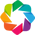

In [2]:
import holoviews as hv
hv.extension("bokeh")

In [ ]:
hv.Scatter